# Background

Richard Wen  
rwen@ryerson.ca  

This notebook details the implementation of object detection models based on the [Haar Cascade Classifier](http://docs.opencv.org/3.2.0/dc/d88/tutorial_traincascade.html) by [Viola and Jones (2001)](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf) available in the [Open Source Computer Vision (OpenCV)](http://opencv.org/) software.

## 1.0 Requirements

* [Anaconda Python 3](https://www.continuum.io/downloads)
* [matplotlib](https://matplotlib.org/)
* [numpy](http://www.numpy.org/)

### 1.1 Setup

Import the following modules:

In [1]:
%matplotlib inline

from math import *
from matplotlib import colors
from matplotlib.patches import Polygon
from os import makedirs, path

import numpy as np
import matplotlib.pyplot as plt

### 1.2 Folders

The following folders are required:

In [2]:
if not path.isdir('_img'):
    makedirs('_img')

### 1.3 Functions

The following functions are needed:

In [3]:
def plot_haars(haars, save_path=None, save_dpi=300):
    """Plot and save Haar-like feature examples.
    Args:
        haars (listof numpy.array):
            List of ``numpy.array`` images.
        save_path (str):
            Path to save the examples.
        save_dpi (int):
            Resolution quality of the output file.
    """
    
    # Base plot
    n_feats = len(haars)
    f, ax = plt.subplots(1, n_feats)
    
    # Plot examples
    for i in range(n_feats):
        ax[i].imshow(haars[i], cmap='gray_r')
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
    
    # Save plot
    if save_path is not None:
        plt.savefig(save_path, dpi=save_dpi)
        
def plot_pixels(pixels,
                save_path=None,
                save_dpi=300,
                cmap=colors.ListedColormap(['white']),
                labels=True,
                coords=False,
                func=None):
    """Plot and save Haar-like feature examples.
    Args:
        pixels (listof numpy.array):
            A list of ``numpy.array`` images.
        save_path (str):
            Path to save the examples.
        save_dpi (int):
            Resolution quality of the output file.
        cmap (matplotlib.colors.ListedColormap OR str):
            A ``matplotlib.colors.ListedColormap`` object or a string reference to one.
        labels (bool):
            Whether to plot the values as labels or not.
        coords (bool):
            Whether to plot the coordinates or not.
        func (function):
            A function consuming a ``matplotlib.pyplot.figure`` and
            ``matplotlib.pyplot.axis`` to run before saving the plot.
    """
    
    # Base plot
    f, ax = plt.subplots()
    
    # Remove axis ticks
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    # Pixel borders
    ax.set_xticks(np.arange(-0.5, 10, 1), minor=True);
    ax.set_yticks(np.arange(-0.5, 10, 1), minor=True);
    ax.grid(which='minor', axis='both', linestyle='-', linewidth=2)
    
    # Add pixel value labels
    for (x,y), label in np.ndenumerate(pixels):
        ax.imshow(pixels, cmap=cmap)
        if labels:
            ax.text(x, y, label, ha='center', va='center')
        if coords:
            ax.text(x, y, '\n\n(' + str(x) + ', ' + str(y) + ')', ha='center', va='center')
    
    # Apply custom function
    if func is not None:
        func(f, ax)
    
    # Save plot
    if save_path is not None:
        plt.savefig(save_path, dpi=save_dpi)
      

## 2.0 Viola and Jones Algorithm

The Viola and Jones algorithm provides an efficient object detection process for images using a machine learning approach [1]. The algorithm involves the following steps in order:

1. **Feature creation**: abstraction of pixels into simple rectangular features
2. **Learning classifiers**: learn function for feature selection based on lowest misclassification
3. **Cascading classifiers**: negative sub-window rejection for efficient computation

### 3.0 Feature Creation

The feature creation process involves creating Haar-like features from pixels in an image. Haar-like features are simple rectangular features computed from individual image pixels. Integral images are used to efficiently create Haar-like features from images by computing rectangular sums in constant time. This section provides details on Haar-like features and integral images for object detection in images. 

#### 3.1 Haar-like Features

Haar-like features form abstract representations of individual pixels from a grayscale image. For example, a rectangular region of an image can contain an abstract representation such as a line or an edge, which is defined by the gradient changes between light and dark pixels. The dimensions of each rectangular region are defined by the user, where Viola and Jones [1] suggests that 24 by 24 regions are optimal through empirical observation. In addition to the rectangular regions, Haar-like features consist of additional rectangular sub-regions with aggregated pixel values to capture a simplified structure. Each sub-region containing individual pixels can be either white or black, where the sum of the white regions subtracted from the sum of the black regions produce a single value to be used for object detection.

Two-rectangle edge features proposed by Papageogiou et al. [2]:

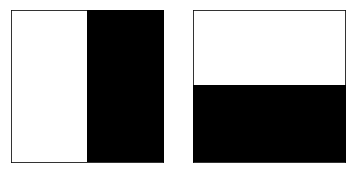

In [4]:
papageogiou_haars = [
    np.array([
        [-1, 1],
        [-1, 1]
    ]),
    np.array([
        [-1, -1],
        [1, 1]
    ])
]
plot_haars(papageogiou_haars, '_img/haars_papageogiou.pdf')

Three-rectangle line features from three feature rectangles introduced by Viola and Jones [1]:

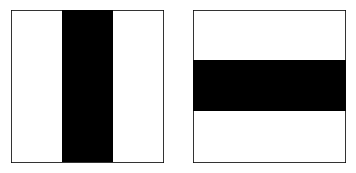

In [5]:
violajones_haars = [
    np.array([
        [-1, 1, -1],
        [-1, 1, -1],
        [-1, 1, -1]
    ]),
    np.array([
        [-1, -1, -1],
        [1, 1, 1],
        [-1, -1, -1]
    ])
]
plot_haars(violajones_haars, '_img/haars_violajones.pdf')

Rotated edge and line features proposed by Lienhardt and Maydt [3]:

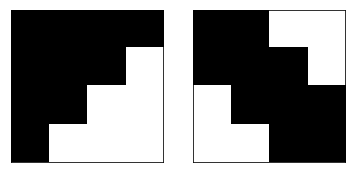

In [6]:
lienmaydt_haars1 = [
    np.array([
        [1, 1, 1, 1],
        [1, 1, 1, -1],
        [1, 1, -1, -1],
        [1, -1, -1, -1]
    ]),
    np.array([
        [1, 1, -1, -1],
        [1, 1, 1, -1],
        [-1, 1, 1, 1],
        [-1, -1, 1, 1]
    ])]
plot_haars(lienmaydt_haars1, '_img/haars_lienmaydt1.pdf')

Center-surround features described by Lienhardt and Maydt [3]:

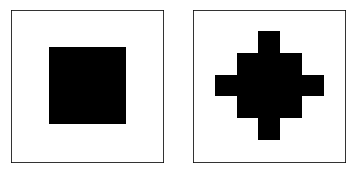

In [7]:
lienmaydt_haars2 = [
    np.array([
        [-1, -1, -1, -1],
        [-1, 1, 1, -1],
        [-1, 1, 1, -1],
        [-1, -1, -1, -1]
    ]),
    np.array([
        [-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, 1, -1, -1, -1],
        [-1, -1, 1, 1, 1, -1, -1],
        [-1, 1, 1, 1, 1, 1, -1],
        [-1, -1, 1, 1, 1, -1, -1],
        [-1, -1, -1, 1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1]
    ])
]
plot_haars(lienmaydt_haars2, '_img/haars_lienmaydt2.pdf')

#### 3.2 Integral Images

Integral images (also known as summed area tables) are pre-computed to efficiently calculate sums in rectangular regions of an image [4]. An integral image is created by inclusively summing each pixel in the original image by the pixels that are to the left and above as seen in the following Equation:

$$ii(x, y) = \sum_{x_i \leq x, y_i \leq y}{i(x_i, y_i)}$$

where $ii(x,y)$ is the integral image at row $x$ and column $y$, and $i(x_i, y_i)$ is the original image pixels that are to the left and above $ii(x,y)$.

In [8]:
def ii_xy(i, x, y):
    """Calculate integral pixel of image i at row x and column y.
    Args:
        i (numpy.array):
            A ``numpy.array`` of the original image.
        x (int):
            Row of integral image.
        y (int):
            Column of integral image.
    Returns:
        A ``numpy.array`` of the integral image.
    """
    xi_lte_x = range(x + 1) # xi <= x
    yi_lte_y = range(y + 1) # yi <= y
    ii = sum([i[xi, yi] for xi in xi_lte_x for yi in yi_lte_y])
    return ii

The sum of rectangular regions can be then be efficiently calculated using the pixel values of the pre-computed integral image as seen in the following Equations:

A rectangular region is defined by a pair of top-left and bottom-right corner coordinates:

$$(x_1, y_1), (x_2, y_2)$$

where $(x_1, y_1)$ are the top-left coordinates of the rectangular region, and 
$(x_2, y_2)$ are the bottom-right coordinates of the rectangular region.

Four integral image pixel values relative to the top-left and bottom-right coordinates of the rectangular region are defined by:

$$
A = ii(x_1 - 1, y_1 - 1)
    \begin{cases}
        0: \text{if} & x_1 - 1 \not\in \left\{ x_{min} \dots x_{max} \right\} \\
        0: \text{if} & y_1 - 1 \not\in \left\{ y_{min} \dots y_{max} \right\} \\
    \end{cases}
$$

$$
B = ii(x_2, y_1 - 1)
    \begin{cases}
        0: \text{if} & x_2 \not\in \left\{ x_{min} \dots x_{max} \right\} \\
        0: \text{if} & y_1 - 1 \not\in \left\{ y_{min} \dots y_{max} \right\} \\
    \end{cases}
$$

$$
C = ii(x_1 - 1, y_2)
    \begin{cases}
        0: \text{if} & x_1 - 1 \not\in \left\{ x_{min} \dots x_{max} \right\} \\
        0: \text{if} & y_2 \not\in \left\{ y_{min} \dots y_{max} \right\} \\
    \end{cases}
$$

$$
D = ii(x_2, y_2)
    \begin{cases}
        0: \text{if} & x_2 \not\in \left\{ x_{min} \dots x_{max} \right\} \\
        0: \text{if} & y_2 \not\in \left\{ y_{min} \dots y_{max} \right\} \\
    \end{cases}
$$

where if the coordinates $x_1, y_1, x_2, y_2$ are outside the $x_{min}, y_{min}, x_{max}, y_{max}$ dimensions of the integral image $ii$, then the value will be 0, otherwise the respective pixel values from $ii$ of $A, B, C, D$ are assigned.

The sum of the pixel values inside the original image is given by:

$$S_i(x_1, y_1, x_2, y_2) = D - B - C + A$$

where $S_i(x_1, y_1, x_2, y_2)$ is the sum of all pixel values of the original image $i$ inside the rectangular region, which is defined by the top-left coordinates $x_1, y_1$ and bottom-right coordinates $x_2, y_2$.

The brute force method for the sum of all pixels inside the rectangular region requires the access of $n$ pixels inside the rectangular region ($O(n)$), while the integral image enables the sum to be computed by at most 4 pixel accesses in the integral image at constant time ($O(1)$). The integral images can be used to process Haar-like features efficiently as two-rectangle features require at most 8 pixel accesses, and three-rectangle features require at most 12 accesses for features of any dimension.

In [9]:
def Si(x1, y1, x2, y2, ii):
    """Adds a rectangular region and integral pixel letters to a pixel plot.
    Args:
        x1 (int):
            The row coordinate for the top-left corner of the rectangular region.
        y1 (int):
            The column coordinate for the top-left corner of the rectangular region.
        x2 (int):
            The row coordinate for the bottom-right corner of the rectangular region.
        y2 (int):
            The column coordinate for the bottom-right corner of the rectangular region.
        ii (numpy.array):
            A ``numpy.array`` of the integral image.
    Returns:
        A number representing the sum of pixels inside the rectangular region.
    """
    
    # Define dimensions of ii
    xmin = 0
    xmax = ii.shape[0]
    ymin = 0
    ymax = ii.shape[1]
    
    # Define zero conditions of A, B, C, D
    A_zero = x1 - 1 < xmin or x1 - 1 > xmax or y1 - 1 < ymin or y1 - 1 > ymax
    B_zero = x2 < xmin or x2 > xmax or y1 - 1 < ymin or y1 - 1 > ymax
    C_zero = x1 - 1 < xmin or x1 - 1 > xmax or y2 < ymin or y2 > ymax
    D_zero = x2 < xmin or x2 > xmax or y2 < ymin or y2 > ymax
    
    # Calculate sum of rectangular region Si
    A = 0 if A_zero else ii[x1 - 1, y1 - 1]
    B = 0 if B_zero else ii[x2, y1 - 1]
    C = 0 if C_zero else ii[x1 - 1, y2]
    D = 0 if D_zero else ii[x2, y2]
    Si = D - B - C + A
    return Si

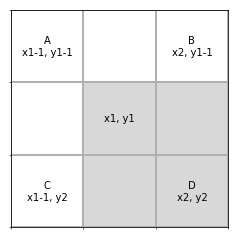

In [10]:
# Original image i
i = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

# Rectangular region
x1, y1 = (1, 1) # top-left
x2, y2 = (2, 2) # bottom-right

# Integral image pixel coordinates
A = (x1 - 1, y1 - 1)
B = (x2, y1 - 1)
C = (x1 - 1, y2)
D = (x2, y2)

# Plot
def add_Si_example(f, ax):
    """Adds a rectangular region and integral pixel letters to a pixel plot.
    Args:
        f (matplotlib.pyplot.figure):
            A ``matplotlib.pyplot.figure`` object.
        ax (maplotlib.pyplot.axis):
            A ``matplotlib.pyplot.axis`` axis object.
    """
    
    # Add rectangular region
    coor = [
        (y1 - 0.5, x1 - 0.5),
        (y2 + 0.5, x1 - 0.5),
        (y2 + 0.5, x2 + 0.5),
        (y1 - 0.5, x2 + 0.5)
    ]
    poly = Polygon(coor, color='gray', alpha=0.3)
    ax.add_patch(poly)
    ax.text(x1, y1, 'x1, y1', ha='center', va='center')
    
    # Add integral pixel letter labels
    ax.text(A[0], A[1], 'A\nx1-1, y1-1', ha='center', va='center')
    ax.text(B[0], B[1], 'B\nx2, y1-1', ha='center', va='center')
    ax.text(C[0], C[1], 'C\nx1-1, y2', ha='center', va='center')
    ax.text(D[0], D[1], 'D\nx2, y2', ha='center', va='center')
plot_pixels(i, '_img/integral_sum.pdf', func=add_Si_example, labels=False)

**Example**

An example of calculating an integral image and summing a rectangular region is provided below.

Given an original image $i$ with 4 rows by 4 columns where each pixel has a value of 1 and coordinates are defined by $(x, y)$:

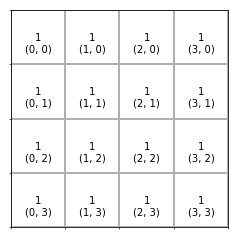

In [11]:
# Original image i
i = np.array([
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1]
])
plot_pixels(i, '_img/integral_i.pdf', coords=True)

The integral image $ii$ for the first two rows and columns can be computed as follows:

* **Row 1, Column 1**: $ii(1,1) = i(1,1)$
* **Row 1, Column 2**: $ii(1,2) = i(1,1) + i(1,2) = 1 + 1 = 2$
* **Row 2, Column 1**: $ii(2,1) = i(1,1) + i(2,1) = 1 + 1 = 2$
* **Row 2, Column 2**: $ii(2,2) = i(1,1) + i(1,2) + i(1,3) + i(1,4) = 1 + 1 + 1 + 1 = 4$

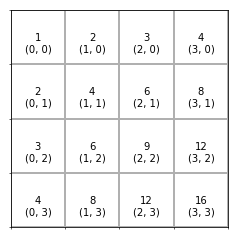

In [12]:
# Initiate integral image ii as copy of i
ii = np.copy(i)

# Get x rows and y columns for ii
rows = range(ii.shape[0])
columns = range(ii.shape[1])

# For each x and y, compute the integral pixels
for x in rows:
    for y in columns:
        ii[x, y] = ii_xy(i, x, y)
plot_pixels(ii, '_img/integral_ii.pdf', coords=True)

A 3 by 3 rectangular region in gray for the original image, which requires 9 array accesses to calculate the sum of 9, is given below:

* Bottom-left corner of region: $x_1, y_1 = 1, 1$
* Top-left corner of region: $x_2, y_2 = 3, 3$

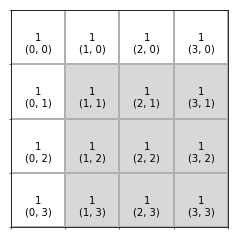

In [13]:
# Rectangular region
x1, y1 = (1, 1) # top-left
x2, y2 = (3, 3) # bottom-right

# Plot
def add_rectangle(f, ax):
    """Adds a rectangular region to a pixel plot.
    Args:
        f (matplotlib.pyplot.figure):
            A ``matplotlib.pyplot.figure`` object.
        ax (maplotlib.pyplot.axis):
            A ``matplotlib.pyplot.axis`` axis object.
    """
    
    # Add rectangular region
    coor = [
        (y1 - 0.5, x1 - 0.5),
        (y2 + 0.5, x1 - 0.5),
        (y2 + 0.5, x2 + 0.5),
        (y1 - 0.5, x2 + 0.5)
    ]
    poly = Polygon(coor, color='gray', alpha=0.3)
    ax.add_patch(poly)
plot_pixels(i, '_img/integral_i_rectangle.pdf', func=add_rectangle, coords=True)

The integral image can be used to calculate the sum of 9 with 4 array accesses instead:

* Recall that $x_1, y_1 = 1, 1$ and $x_2, y_2 = 3, 3$
* $A = ii(x_1 - 1, y_1 - 1) = ii(1 - 1, 1 - 1) = ii(0, 0) = 1$
* $B = ii(x_2, y_1 - 1) = ii(3, 1 - 1) = ii(3, 0) = 4$
* $C = ii(x_1 - 1, y_2) = ii(1 - 1, 3) = ii(0, 3) = 4$
* $D = ii(x_2, y_2) = ii(3, 3) = 16$
* $S_i(1, 1, 3, 3) = D - B - C + A = 16 - 4 - 4 + 1 = 9$

The sum of the rectangular region of ii is: 9


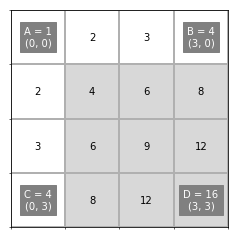

In [14]:
# Integral image pixel coordinates
A = (x1 - 1, y1 - 1)
B = (x2, y1 - 1)
C = (x1 - 1, y2)
D = (x2, y2)

# Plot
def add_ABCD(f, ax):
    """Adds a rectangular region to a pixel plot.
    Args:
        f (matplotlib.pyplot.figure):
            A ``matplotlib.pyplot.figure`` object.
        ax (maplotlib.pyplot.axis):
            A ``matplotlib.pyplot.axis`` axis object.
    """
    
    # Add rectangular region
    coor = [
        (y1 - 0.5, x1 - 0.5),
        (y2 + 0.5, x1 - 0.5),
        (y2 + 0.5, x2 + 0.5),
        (y1 - 0.5, x2 + 0.5)
    ]
    poly = Polygon(coor, color='gray', alpha=0.3)
    ax.add_patch(poly)
    
    # Add integral pixel letter labels
    ax.text(A[0], A[1], 'A = 1\n(0, 0)', color='white', backgroundcolor='gray', ha='center', va='center')
    ax.text(B[0], B[1], 'B = 4\n(3, 0)', color='white', backgroundcolor='gray', ha='center', va='center')
    ax.text(C[0], C[1], 'C = 4\n(0, 3)', color='white', backgroundcolor='gray', ha='center', va='center')
    ax.text(D[0], D[1], 'D = 16\n(3, 3)', color='white', backgroundcolor='gray', ha='center', va='center')
print('The sum of the rectangular region of ii is: ' + str(Si(x1, y1, x2, y2, ii)))
plot_pixels(ii, '_img/integral_ii_rectangle.pdf', func=add_ABCD)

### Learning Classifiers

A machine learning algorithm known is used to learn classifiers for feature selection. Machine learning algorithms seek to optimize performance measures by learning from examples, known as training data, to generalize on new examples not seen in the learning process [5]. Classifiers are models generated by machine learning algorithms to determine whether the input data belongs to one or more known categories (classes) [6]. Adaboost combines several weak classifiers, using a process called boosting, to create a strong classifier [7, 8]. Weak classifiers are algorithms that perform slightly better than random guessing (for example, classifying a data sample correctly more than 50% of the time). These weak classifiers are combined to produce a strong classifier, which performs better than the individual weak classifiers, using a process called *boosting*. Boosting refers to iteritively learning weak classifiers using a vector of weights, where the weights are re-calculated based on performances of previous weak classifiers.

A modified Adaboost algorithm based on weak classifiers is described from Viola and Jones [9] below.

A set of example images, their feature values, and their label (positive or negative) are given by: 

$$(x_i, f_{i, j}, y_i) \ \text{for} \ i \dots n_i \ \text{and} \ j \dots n_j \text{, such that} \ y_i \in \left\{0, 1 \right\} $$

where $x_i$ is example image $i$, $f_{i, j}$ is feature $j$ for image $i$, $y_i$ are the labels for example image $i$ (0 being negative and 1 being positive), $n_i$ is the number of example images, and $n_j$ is the number of features for $xi$.

A set of weights are initialized for each of the example images:

$$w_{1,i} = 
    \begin{cases}
        \frac{1}{2m}: \text{if} \ y_i = 0 \\
        \frac{1}{2l}: \text{if} \ y_i = 1\\
    \end{cases}
$$

where $m$ is the number of negative example images, and $l$ is the number of positive images.

In [15]:
def w1i(yi):
    """Function for initializing a set of weights.
    Args:
        yi (numpy.array):
            A ``numpy.array`` representing positive or negative labels
            for each example image xi in order.
    Returns:
        A ``numpy.array`` representing the initialized set of weights.
    """
        
    # Get m negatives and l positives
    m = sum(yi[yi == 0])
    l = sum(yi[yi == 1])

    # Initialize weights as 1/(2m) and 1/(2l)
    return [1 / (2 * m) if y == 0 else 1 / (2 * l) for y in yi]

The inputs are $(x_i, f_{i,j}, y_i)$ and an initial set of weights $w_{i,j}$.

$For \ t=1 \ \dots \ T$ iterations:

* Create a probability distribution of normalized weights $w_{t,i}$, for each $t$, such that $w_{t,i}$ is in the range of 0 to 1 and sums to 1:

    $$w_{t,i} = \frac{w_{t,i}}{\sum_{k=1}^{n_i}{w_{t,k}}}$$
    
    where $n_i$ is the number of example images, and $\sum_{k=1}^{n_i}{w_{t,k}}$ is the sum of the weights for all images.

In [16]:
def wti(w):
    """Function for normalizing a set of weights.
    Args:
        w (numpy.array):
            A ``numpy.array`` representing the set of weights.
    Returns:
        A ``numpy.array`` with the normalized set of weights in
        the range of 0 to 1.
    """
    return w / sum(w)

* Train a weak classifier $h_j(x)$ for each feature $j$ using example images $xi$ and their labels $yi$. Viola and Jones uses a decision stump as the weak classifier defined below:

    $$h(x, f, p, \theta) = 
        \begin{cases}
            1: \text{if} \ p \ f(x) \lt p \theta \\
            0: \text{otherwise} \\
        \end{cases}
    $$

    where $h(x)$ is the weak classifier for a feature given example image $x$ defined by a sub-window (such as a 24 by 24 rectangular sub-region), $p$ is the parity representing the direction of the inequality sign (positive or negative), $f(x)$ is the single value for the rectangular feature of $x$, and $\theta$ is a threshold. The threshold $\theta$ is learned by training a decision stump to first order the feature values $f$ from lowest to highest for each image $x$, followed by selecting the feature value that optimizes $h$ for the lowest error measure defined by Viola and Jones:
    
    $$e = \min(S^+ + (T^- - S^-), S^- + (T^+ - S^+))$$
    
    where $S^+$ is the sum of positive weights below the current feature value $f$, $S^-$ is the sum of negative weights below the current feature value $f$, $T^+$ is the total sum of all positive example weights, and $T^-$ is the total sum of all negative example weights. This error can be interpreted as a measure of the minimum error of labeling examples below a feature value and above a feature value given the weights [9]. The feature value with the minimum error $e$ is then selected as the threshold $\theta{_j}$.

In [17]:
def e(S_plus, S_minus, T_plus, T_minus):
    """Function representing a weak classifier.
    Args:
        S_plus (num):
            Numeric value or ``numpy.array`` of the sum(s) of positive weights 
            below a feature j.
        S_minus (num):
            Numeric value or ``numpy.array`` of the sum(s) of negative weights 
            below a feature j.
        T_plus (num):
            Numeric value or ``numpy.array`` of the sum(s) of positive weights.
        T_minus(num)):
            Numeric value or ``numpy.array`` of the sum(s) of negative weights.
    Returns:
        A numeric value of the error for a decision stump weak classifier
        given a feature j for example i.
    """
    return min([S_plus + (T_minus - S_plus), S_minus + (T_plus - S_minus)])

def thetaj(fj, yi, wti):
    """Function representing a weak classifier.
    Args:
        f (numpy.array):
            A ``numpy.array`` of feature j values for each example image.
        wti (numpy.array):
            A ``numpy.array`` with the normalized set of weights in 
            the range of 0 to 1 for each example image.
    Returns:
        A numeric value of the optimized theta threshold.
    """
    ni = len(yi)
    
    # Sort weights, labels, and features
    sort = np.argsort(fj) # sorted indices
    fj = fj[sort] # sorted feature values
    yi = yi[sort] # sorted labels
    wti = wti[sort] # sorted weights
    
    # Obtain sums of all positive and negative weights
    T_plus = sum(wti[yi == 1])
    T_minus = sum(wti[yi == 0])
    
    # Get the errors for each feature j
    ei = np.zeros(ni)
    for i in range(ni):
        below = range(i + 1)
        positives = yi[below] == 1
        negatives = yi[below] == 0
        S_plus = sum(wti[below][positives])
        S_minus = sum(wti[below][negatives])
        ei[i] = e(S_plus, S_minus, T_plus, T_minus)
        
    # Return the threshold
    emin = np.argsort(ei)[0]
    return fj[emin]

class h:
    """Class for a weak hypothesis classifier.
    Args:
        p (1 or -1):
            A number representing the parity.
        theta(num):
            A number representing the optimized threshold learned from
            a set of training examples.
    Attributes:
        p (1 or -1):
            Same as argument p.
        theta (num):
            Same as argument theta.
    Examples::
        # Some example values
        f = np.random.rand(1, 5) # feature values
        y = np.array([1,0,0,1,1]) # labels
        w = wti(w1i(y)) # normalized weights
        
        # Optimize threshold
        theta = thetaj(f, y, w)
    """
    def __init__(self, p, theta):
        self.p = p
        self.theta = theta
        
    def classify(self, f):
        """Method for classifying an example given its feature value.
        Args:
            f (num):
                A number representing the feature value for an example
                image xi.
        Returns:
            A numeric value of 1 if ``self.p`` * ``f`` < ``self.p`` * ``self.theta`` 
            and 0 otherwise.
        """
        p = self.p
        theta = self.theta
        return 1 if p * f < p * theta else 0
    

* Choose the classifier $h_j$ with the lowest error $\epsilon_j$ defined by:
    
    $$\epsilon_j = \sum_i^n{w_i \left\lvert h_j(x_i, f_j, p, \theta_j) - y_i \right\rvert}$$
    
    where $h_j(x_i, f_j, p, \theta_j)$ is the predicted label (0 negative or 1 for positive), and $y_i$ is the true label. 
    
    The classifier with the lowest error $h_t$ minimizes $\epsilon_j$ by optimizing $\theta_j$ and $p$:
    
    $$\min_{\theta_j \ \in \ \mathbb{R}, \ p \ \in \ \left\{ +1,-1 \right\}}\epsilon_j(x_i, f_j, p, \theta_j)$$

In [18]:
def ej(wi, hj, yi):
    """Function for measuring weak classifier error.
    Args:
        wi (numpy.array):
            A ``numpy.array`` representing the set of normalized weights.
        hj (numpy.array):
            A ``numpy.array`` of the predicted labels of example images xi.
        yi (numpy.array):
            A ``numpy.array`` of the true labels of example images xi.
    Returns:
        A ``numpy.array`` of the error measures for each weak classifier.
    """
    return sum(wi * np.absolute(hj - yi))

* Update the weights using the following equation:
    
    $$w_{t+1,i} = w_{t,i} \beta_t^{1-e_j}$$
    
    where $\beta_t$ is $\frac{\epsilon_t}{1-\epsilon_t}$.

In [19]:
def wti_update(wti, ej):
    """Function for measuring weak classifier error.
    Args:
        wti (numpy.array):
            A ``numpy.array`` representing the set of normalized weights.
        ej (numpy.array):
            A ``numpy.array`` of the error values of each classifier hj.
    Returns:
        A ``numpy.array`` of the updated weights for each example image xi.
    """
    beta = ej / (1 - ej)
    return wti * pow(beta, 1 - ej)

After going through the iterations $T$, the final strong classifier $C(x)$ is then:

$$C(x) = 
\begin{cases}
    1: \text{if} \ \sum_{t=1}^T{\alpha_t h_t(x) \geq \frac{1}{2} \sum_{t=1}^T{\alpha_t}} \\
    0: \text{otherwise} \\
\end{cases}
$$

where $\alpha_t = \log \frac{1}{B_t}$, and $h_t$ are the weak classifiers learned from $t$ iterations. This strong classifier is the combination of the weak classifiers.

In [20]:
class C:
    """Method for making a strong classification from weak classifiers.
    Args:
        ht (listof h):
            A list of weak classifier ``h`` objects with method classify(f).
        alpha (numy.array):
            A ``numpy.array`` representing the alpha values for iteration t.
        beta (num):
            A ``numpy.array`` representing the beta values for iteration t.
    Attributes:
        ht (listof h):
            Same as argument ``ht``.
        alpha (num):
            Same as argument ``alpha``.
        beta (num):
            Same as argument ``beta``.
    """
    def __init__(self, ht, alpha, beta):
        self.ht = ht
        self.alpha = alpha
        self.beta = beta
        
    def classify(self, fj):
        """Method for making a strong classification from weak classifiers.
        Args:
            f (numpy.array):
                A ``numpy.array`` of feature values for an example
                image x.
        Returns:
            A numeric value of the predicted label 1 for positive and 0 for negative.
        """
        alpha = log(1 / beta)
        ht_x = [ht.classify(f) for f in fj for ht in self.ht]
        return 1 if sum(alpha * ht_x) >= (1/2) * sum(alpha) else 0

## References

* [1] [Rapid Object Detection using a Boosted Cascade of Simple Features](http://wearables.cc.gatech.edu/paper_of_week/viola01rapid.pdf) by Paul Viola and Michael Jones
* [2] C. Papageorgiou, M. Oren, and T. Poggio. A general framework for object detection. In International Conference on Computer Vision, 1998.
* [3] [An Extended Set of Haar-like Features for Rapid Object Detection](https://pdfs.semanticscholar.org/72e0/8cf12730135c5ccd7234036e04536218b6c1.pdf) by Rainer Lienhart and Jochen Maydt
* [4] [Summed-Area Tables for Texture Mapping](http://www.florian-oeser.de/wordpress/wp-content/2012/10/crow-1984.pdf) by Fraklin C. Crow
* [5] [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) by Pedro Domingos
* [6] [Machine learning: a review of classification and combining techniques](http://www.cs.bham.ac.uk/~pxt/IDA/class_rev.pdf) by Sotiris B. Kotsiantis, Ioannis D Zaharakis, and  Panayotis E Pintelas
* [7] [A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting](http://www.face-rec.org/algorithms/Boosting-Ensemble/decision-theoretic_generalization.pdf) by Yoav Freund and Robert E. Schapire
* [8] [A Short Introduction to Boosting](http://www.yorku.ca/gisweb/eats4400/boost.pdf) by Yoav Freund and Robert E. Schapire
* [9] [Robust Real-Time Face Detection](http://www.vision.caltech.edu/html-files/EE148-2005-Spring/pprs/viola04ijcv.pdf) by Paul Viola and Michael Jones
* [Detecting pedestrians using patterns of motion and appearance](http://www.merl.com/publications/docs/TR2003-90.pdf) by Paul Viola, Michael Jones, and Daniel Snow. 
* [Haar-like features with optimally weighted rectangles for rapid object detection](https://pdfs.semanticscholar.org/4192/79b5d21234737b10715fd785eeb51b317767.pdf) by Sri-Kaushik Pavani, David Delgado, Alejandro F. Frangi
* [Implementing the Viola-Jones Face Detection Algorithm](https://pdfs.semanticscholar.org/40b1/0e330a5511a6a45f42c8b86da222504c717f.pdf) by Ole Helvig Jensen
